<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/easyagents_line_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Line World

* an agent lives in a finite linear world of uneven elements
* at each moment it is in a certain position
* initial position is the middle
* some positions gain rewards, some don't
* rewards are between 0 and 15
* agent can either move left or right
* Objective: maximize total reward = sum(rewards) + sum(steps)
* Cost per step: -1
* Done Condition: agent is at pos 0 or total reward <= -20

<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/line-world.png?raw=1'>

### Install gym, tensorflow, tf-agents,..., setup display

In [0]:
import sys
if 'google.colab' in sys.modules:
    !pip install easyagents >/dev/null

In [0]:
import easyagents
easyagents.__version__

'1.3.0'

##### suppress package warnings, in colab: load additional packages for rendering

In [0]:
import sys
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

# Define Gym Environment

<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/gym.png?raw=1'>

http://gym.openai.com/

## Our focus is a bit different

* the gym has originally been designed by reinforcement learning researchers as a suite of environments to comapre difference algorithms
* it has a nice API supported by all major reinforcement learning libraries
* since we are practitioners we use that same API to build our own environments

## How does the API look like?
* an environment is a Python class
* `step` as its main method
* it takes the action and returns the new observation, the reward, and if the game is done
* the environment also makes you defined how an observation looks like and what actions can be performed
* this is important to configure the agent
* in our case the agents strategy is always defined as a TensorFlow neural network
* it is configured to take the observationa as input and outputs a probability for each action
* this probability describes the chance of this action to be the most successful
* you would also defined an `__init__` (constructor), a `reset` method, and a `render` method

## What you need to define
1. Actions
1. Observation
1. Reward
1. Game done?

## Skeleton of an Environment
```python
class MyEnv(gym.Env):
  def __init__(self):
      # set up the environment

    def step(self, action):
        # make the action have an impact on the environment
        # and return the information the algorithms need
        return observation, reward, done, info

    def reset(self):
        # reset this environment to the initial state and return the according observation
        return observation

    def render(self, mode='ansi'):
        # spits out a human readable rendering of the environment
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
  
```


https://gym.openai.com/

https://github.com/openai/gym/blob/master/docs/creating-environments.md



## Good sanity check

_Would you as a human be able to play the game based on the observation and reward you get?_


In [0]:
import numpy as np
import math

import gym
from gym import error, spaces, utils

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

LEFT = 0
RIGHT = 1

class LineWorldEnv(gym.Env):

    # constructor sets up the properties of the environment
    # most important action space, observation space and reward range
    def __init__(self, world=[10, 0, 0, 5, 0, 2, 15]):
        self.world = np.array(world)
        # the agent can perform  different actions
        number_of_actions = 2
        self.action_space = spaces.Discrete(number_of_actions)

        self.size_of_world = len(world)

        self.max_reward = 15
        self.min_reward = 0

        # STEP II
        # this needs to match size and range of what you return in
        # get_observation 
        # definition of world is a list in self.world
        # the length of the world is in self.size_of_world

        # CHANGE HERE START

        self.observation_size = 1 # this is a pretty random number

        # CHANGE HERE END
        
        # the environment's current state is described by the position of the agent and the remaining rewards
        low = np.full(self.observation_size, self.min_reward)
        high = np.full(self.observation_size, self.max_reward)
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)

        self.reward_range = (-1, 1)
        # 32 is only theoretical, because we need to travel at least 9 steps, leaving us with 23 practically
        self.optimum = self.world.sum() - 9

        self._figure = None

        self.reset()

    # STEP I
    # position: [self.pos]
    # remaining rewards: self.remaining_rewards
    # if you want to append two lists/arrays use np.append(list1, list2)

    # CHANGE HERE START

    def get_observation(self):
        return np.full(self.observation_size, 0)

    # CHANGE HERE END

    def reset(self):
        self.total_reward = 0
        self.done = False
        self.pos = math.floor(len(self.world) / 2)
        self.steps = 0

        self.remaining_rewards = np.array(self.world, copy=True)
        return self.get_observation()

    def step(self, action):
        if action == LEFT and self.pos != 0:
          self.pos -= 1
        elif self.pos < self.size_of_world -1:
          self.pos += 1

        reward = self.remaining_rewards[self.pos] - 1
        normalized_reward = reward / self.optimum
        self.total_reward += normalized_reward
        self.remaining_rewards[self.pos] = 0

        if self.pos == 0 or self.total_reward * self.optimum <= -20:
          self.done = True
        self.steps += 1

        observation = self.get_observation()
        info = {'reward': reward }
        return observation, normalized_reward, self.done, info

    def _render_to_ansi(self):
        return 'position: {position}, remaining rewards: {rewards}, total reward so far: {total}, normalized total reward: {normalized_total}, steps so far: {steps}, game done: {done}'.format(
            position=self.pos, 
            rewards=self.remaining_rewards, 
            total=self.total_reward * self.optimum, 
            normalized_total = self.total_reward,
            done=self.done,
            steps=self.steps)              

    def _render_to_figure(self):
        """ Renders the current state as a graph with matplotlib """
        if self._figure is not None:
            plt.close(self._figure)
        self._figure, ax = plt.subplots(1, figsize=(8, 4))
        ax.set_ylim(bottom=-1, top=self.max_reward + 1)
        x = np.arange(0, self.size_of_world, 1, dtype=np.uint8)
        y = self.remaining_rewards
        plt.plot([self.pos, self.pos], [0, 2], 'r^-')
        ax.scatter(x, y, s=75)
        self._figure.canvas.draw()
        
    def _render_to_human(self):
        """ show render_to_figure in a jupyter cell. 
            the result of each call is rendered in the same cell"""
        clear_output(wait=True)
        self._render_to_figure()
        plt.pause(0.01)
        
    def _render_to_rgb(self):
        """ convert the output of render_to_figure to a rgb_array """
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result        

    def render(self, mode='ansi'):
        if mode == 'ansi':
            return self._render_to_ansi()
        elif mode == 'human':
            return self._render_to_human()
        elif mode == 'rgb_array':
            return self._render_to_rgb()
        else:
            super().render(mode=mode)


# Hands-On 1: Try out our environment

_use yourself to simulate the agent_

* Create an environment and play the game to the end manually using the cells below
* Use a sequence of left and right commands to find the best solution possible
* Show yourself only local observations and reward for each step and choose an action
* Would this be sufficent for a good reward?
* What reward do you get? What is the optimum?

In [0]:
env = LineWorldEnv()

In [0]:
# shows the raw observation, this does not look too good
env.reset()

array([0])

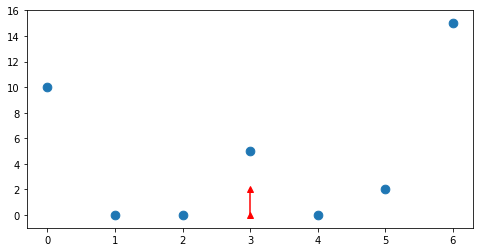

In [0]:
env.render(mode='human')

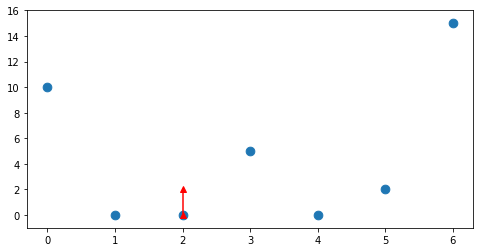

In [0]:
observation, normalized_reward, done, info = env.step(LEFT)
env.render(mode='human')

In [0]:
observation, normalized_reward, done, info

(array([0]), -0.043478260869565216, False, {'reward': -1})

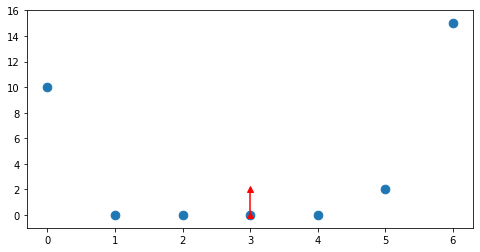

In [0]:
observation, normalized_reward, done, info = env.step(RIGHT)
env.render(mode='human')

In [0]:
observation, normalized_reward, done, info

(array([0]), 0.17391304347826086, False, {'reward': 4})

# Train policy with tfagents PpoAgent

Wall time: 38.4 s


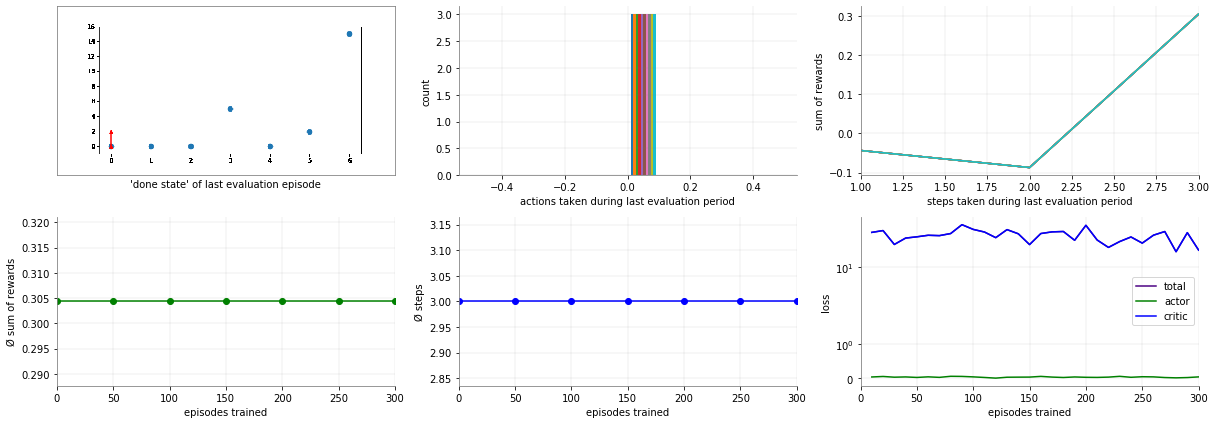

In [0]:
%%time

from easyagents.env import register_with_gym
from easyagents.agents import PpoAgent
from easyagents.callbacks import log, plot

env_name = "LineWorld-v0"
register_with_gym(gym_env_name=env_name, entry_point=LineWorldEnv, max_episode_steps=100)

ppoAgent = PpoAgent(gym_env_name = env_name, fc_layers=(500,500,500))

plots = [plot.State(), 
         plot.Actions(), 
         plot.StepRewards(), 
         plot.Rewards(), 
         plot.Steps(), 
         plot.Loss(),
         plot.ToMovie()]
ppoAgent.train(plots, 
               num_iterations = 30, 
               num_episodes_per_iteration = 10,
               max_steps_per_episode = 20)

# Hands-On 2: Define the observation in a way that allows the agent to train

_Change the environment code above_

* You see the agent does not learn with the observation given. Why is that?

* Find an observation that works and impement it in `get_observation`

* You need to update the `observation_space` to the same shape of your observation at the same time.

* There are guiding comments in the code above, make sure you follow the steps described in the comments

* Use env.reset() to check the observation

* Why does it work? Is this the best observation? How would you even know?

* Do you think this would be sufficient for a real world example? If not, what is missing?

 # STOP HERE

## Play (turn ouput into a movie)

In [0]:
ppoAgent.play([plot.State(), plot.StepRewards(num_steps_between_plot=1), plot.Actions(), plot.ToMovie(fps=3)], 
              num_episodes=5, max_steps_per_episode=20)

Play uses the previously trained policy. We play for 5 episodes, each with max 20 steps. All steps are rendered into a movie with a frame rate of 3 steps per second.

# How does Reinforcement Learning really work?

Presentation on slides

# Hands-On 3: Make your notebook work with Reinforce

* What parts do you need to change?

* How do the results compare to what you have seen with PPO?

* Can you tweak the parameters (like the size of the neural network) to improve the results?


In [0]:
from easyagents.agents import ReinforceAgent
ReinforceAgent?

# Next Steps:

## Generalizing our Environment

* solving a single set up of our line world is not very realistic
* there should be variations to rewards, size, and starting position
* while training with with each episode we could randomly set rewards and starting postition
* different sizes could be simulated by using a fixed max size with a random number of padding entires (e.g -1) at the end
